# Ciencia de datos (CC408) - Primavera 2024

## Trabajo Práctico 3

### Parte I: Limpieza de la base

In [36]:
#!pip install openpyxl
!pip install statsmodels

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.8 MB 2.1 MB/s eta 0:00:05
   --- ------------------------------------ 0.8/9.8 MB 1.8 MB/s eta 0:00:06
   ---- ----------------------------------- 1.0/9.8 MB 1.6 MB/s eta 0:00:06
   ----- ---------------------------------- 1.3/9.8 MB 1.6 MB/s eta 0:00:06
   ------ --------------------------------- 1.6/9.8 MB 1.4 MB/s eta 0:00:06
   --------- ------------------------------ 2.4/9.8 MB 1.7 MB/s eta 0:00:05
   ----------- ---------------------------- 2.9/9.8 MB 1.8 MB/s eta 0:00:04
   ------------- -------------------------- 3.4/9.8 MB 1.9 MB/s eta 0:00:04
   -------------- ------------------------- 3.7/9.8 MB 1.9 MB/s eta 0:00:04
   ---------------- ----------------------- 3.9/9.8 MB 1.9 MB/s eta 0:00:04
   ------------------ --------------------- 4.5/9.8 MB 1.8 MB/s eta 0:00:03
   ------------------- ---

In [37]:
# Importamos las librerías a usar

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
#from sklearn.metrics import plot_roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier


#### Lectura del documento

In [3]:
## 0. LECTURA DEL DOCUMENTO
df2024 = pd.read_excel('C:/Users/SAMSUNG/Documents/GitHub/CC408-T1-5/TP 3/usu_individual_T124.xlsx')
df2004 = pd.read_stata('C:/Users/SAMSUNG/Documents/GitHub/CC408-T1-5/TP 3/Individual_t104.dta')

#Dirección de Maggie: "C:/Users/magda/OneDrive/Documents/GitHub/CC408-T1-5/TP 3"
#Dirección de Peter: "C:/Users/SAMSUNG/Documents/GitHub/CC408-T1-5/TP 3/usu_individual_T124.xlsx"

#### Filtrado de bases para tener solo Buenos Aires

In [4]:
df_2024_GB = df2024[(df2024['AGLOMERADO'] == 33) | (df2024['AGLOMERADO'] == 32)]
df_2004_GB = df2004[(df2004['aglomerado'] == 'Ciudad de Buenos Aires') | (df2004 ['aglomerado'] == 'Partidos del GBA' )]

df_2004_GB.columns = df_2004_GB.columns.str.upper()
df_2024_GB['IPCF'] =df_2024_GB['IPCF'].astype(int)
#df_2024_GB['AGLOMERADO'].unique()
#df_2004_GB['aglomerado'].unique()

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_14884\3212184527.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2024_GB['IPCF'] =df_2024_GB['IPCF'].astype(int)


#### Preparación de la base de 2004
Se definen diccionarios de cambio para pasarlo a los mismos valores que tiene la base de 2024, se hacen solo los diccionarios de las variables que se van a usar después para la matriz de correlación. 
- Se hacen diccionarios
- Se vuelven a definir los valores a partir de los diccionarios
- Se chequea si hay valores extraños / no validos
- Se eliminan los ingresos y edades negativas y edades demasiado altas
- El resto de valores invalidos (CAT_INAC) se eliminan después cuando se verifique la base de 2024

In [5]:
#diccionarios de cambio 
#LIMPIAR LA MAYOR CANTIDAD DE VARIABLES - NOS VA A SERVIR PARA EL TP 4
# El diccionario de la base de datos está un poco mal hecho, con diferencia a como se guardan los datos. que malditos
h04 = {
    "Varón": 1,
    "Mujer": 2
}

#Esto no aparece
h06 = {
    'Menos de 1 año': 0,
    '98 y más años': 98
}

#esto aparece con signos de pregunta
h07 = {
    "Unido": 1,
    "Casado": 2,
    "Separado o divorciado": 3,
    "Viudo": 4,
    "Soltero": 5
}

#Esto con mayusculas incosistentes
h08 =    {
    'Obra social (incluye PAMI)': 1,
    'Mutual/Prepaga/Servicio de emergencia': 2,
    'Planes y seguros públicos': 3,
    'No paga ni le descuentan': 4,
    'Ns./Nr.': 9,
    'Obra social y mutual/prepaga/servicio de emergencia': 12,
    'Obra social y planes y seguros públicos': 13,
    'Mutual/prepaga/servicio de emergencia/planes y seguros públi': 23,
    'Obra social, mutual/prepaga/servicio de emergencia y planes': 123
}

# 'Secundario incompleto' y en los datos aparece como 'Secuandaria incompleta', así con todo
nivel_ed= {
    'Primaria Incompleta (incluye educación especial)': 1,
    'Primaria Completa': 2,
    'Secundaria Incompleta': 3,
    'Secundaria Completa': 4,
    'Superior Universitaria Incompleta': 5,
    'Superior Universitaria Completa': 6,
    'Sin instrucción': 7,
    'Ns/Nr': 9
}

estado = {
    'Entrevista individual no realizada (no respuesta al cuestion': 0,
    'Ocupado': 1,
    'Desocupado': 2,
    'Inactivo': 3,
    'Menor de 10 años': 4
}

cat_inac = {
    'Jubilado/pensionado': 1,
    'Rentista': 2,
    'Estudiante': 3,
    'Ama de casa': 4,
    'Menor de 6 años': 5,
    'Discapacitado': 6,
    'Otros': 7
}

aglomerado = {
    'Ciudad de Buenos Aires': 33}

In [6]:
df_2004_GB.loc[:,'CAT_INAC'] = df_2004_GB ['CAT_INAC'].replace(cat_inac).astype(int) # Tiene 0 a eliminar
df_2004_GB.loc[:,'CH04'] = df_2004_GB ['CH04'].map(h04).astype(int)
df_2004_GB.loc[:,'CH06'] = df_2004_GB ['CH06'].replace(h06).astype(int)
df_2004_GB.loc[:,'CH07'] = df_2004_GB ['CH07'].map(h07).astype(int)
df_2004_GB.loc[:,'CH08'] = df_2004_GB ['CH08'].map(h08).astype(int)
#df_2004_GB.loc[:,'AGLOMERADO'] = df_2004_GB ['AGLOMERADO'].map(aglomerado).astype(int)
df_2004_GB.loc[:,'NIVEL_ED'] = df_2004_GB ['NIVEL_ED'].replace(nivel_ed).astype(int)
df_2004_GB.loc[:,'ESTADO'] = df_2004_GB ['ESTADO'].map(estado).astype(int)
df_2004_GB['IPCF'] =df_2004_GB['IPCF'].astype(int)


C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_14884\1072544910.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_2004_GB.loc[:,'CAT_INAC'] = df_2004_GB ['CAT_INAC'].replace(cat_inac).astype(int) # Tiene 0 a eliminar
C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_14884\1072544910.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_2004_GB.loc[:,'CAT_INAC'] = df_2004_GB ['CAT_INAC'].replace(cat_inac).astype(int) # Tiene 0 a eliminar
C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_14884\1072544910.py:1: FutureWarning: Setting an item of incompat

##### Entiendo los datos que vamos a usar
##### Observo los valores y frecuencia de esos valores en los datos para revisar que los datos tengan sentido y sigan las claves de los diccionarios oroginales. Se encuentra que CAT_INAC tiene 3617 datos en valor '0' (tiene precibir datos entre 1 y 7)

In [6]:
# CH04 está bien
# CH06 parece que está bien
# CH07 está bien
# CH08 está bien, no se observa '13'
# NIVEL_ED está bien, no se observa '7', o '8'
# ESTADO está bien
# CAT_INAC tiene la mitad de los datos como'0' (son 3617 datos no validos)

lista_valores_matriz = ['CH04', 'CH06', 'CH07', 'CH08', 'NIVEL_ED', 'ESTADO', 'CAT_INAC']
for i in lista_valores_matriz:
    print(df_2004_GB[i].value_counts())

CH04
2    4045
1    3602
Name: count, dtype: int64
CH06
13    153
22    146
14    139
17    138
7     137
     ... 
93      4
98      4
90      3
94      2
96      1
Name: count, Length: 96, dtype: int64
CH07
5    3687
2    2372
1     821
4     429
3     338
Name: count, dtype: int64
CH08
1     3568
4     3296
2      610
12     111
3       47
9       11
23       4
Name: count, dtype: int64
NIVEL_ED
2    1628
1    1406
3    1374
4    1086
7     805
5     701
6     647
Name: count, dtype: int64
ESTADO
1    3079
3    2800
4    1230
2     528
0      10
Name: count, dtype: int64
CAT_INAC
0    3617
3    1594
4     816
5     763
1     668
7     134
6      41
2      14
Name: count, dtype: int64


In [7]:
# Define los límites
maximo_edad = 130 # totalmente arbitrario, pero sirve para sacar extraños muy extraños

# Filtra el DataFrame, manteniendo solo los valores dentro del rango
df_2004_GB = df_2004_GB[(df_2004_GB['IPCF'] >= 0)]
df_2004_GB = df_2004_GB[(df_2004_GB['CH06'] >= 0) & (df_2004_GB['CH06'] <= maximo_edad)]

#### Preparación de base de datos de 2024
Se chequean los valores extraños / sin sentido, se eliminan los invalidos de ingreso y edad. 


In [8]:
# RESET
#df_2024_GB = df2024[(df2024['AGLOMERADO'] == 33) | (df2024['AGLOMERADO'] == 32)]
# La base tiene 7051 observaciones

In [9]:
# Define los límites
maximo_edad = 130 # totalmente arbitrario, pero sirve para sacar extraños muy extraños

# Filtra el DataFrame, manteniendo solo los valores dentro del rango
df_2004_GB = df_2004_GB[(df_2004_GB['IPCF'] >= 0)]
df_2004_GB = df_2004_GB[(df_2004_GB['CH06'] >= 0) & (df_2004_GB['CH06'] <= maximo_edad)]

##### Otra vez, CAT_INAC tiene mucho invalidos

In [10]:
# Me fijo los valores y la frecuencia

#CH07 tiene '9'
#CH08 está bien, no tiene ninguno 123
#NIVEL_ED está bien, no tiene 8 o 9
#ESTADO está bien
#CAT_INAC tiene mitad de los valores como 0 (3576 observaciones no validas)
df_2024_GB['CAT_INAC'].value_counts()

CAT_INAC
0    3576
3    1440
1     717
4     653
5     402
7     186
6      59
2      18
Name: count, dtype: int64

#### Eliminación de ambas bases previo al merge
se elimina los extraños de ambas bases de datos 

In [11]:
valores_validos = {
    'CH04': [1,2],
    'CH07': [1,2,3,4,5],
    'CH08': [1,2,3,4,9,12,13,23,123],
    'NIVEL_ED': [1,2,3,4,5,6,7,8,9],
    'ESTADO': [0,1,2,3,4],
    'CAT_INAC': [0,1,2,3,4,5,6,7] 
} #'CH06' Y 'IPCF' quedan excluidos porque tiene condiciones de min y max

for col in valores_validos.keys():
    df_2024_GB = df_2024_GB[df_2024_GB[col].isin(valores_validos[col])]
    df_2004_GB = df_2004_GB[df_2004_GB[col].isin(valores_validos[col])]

In [12]:
lista_valores_matriz = ['CH04',  'CH07', 'CH08', 'NIVEL_ED', 'ESTADO', 'CAT_INAC'] 
for i in lista_valores_matriz:
    datos = df_2024_GB[i].value_counts()
    print ('los valores de ', i, 'son:', datos)

# CH04 BIEN
# CH06 MAL: TIENE -1
# CH07 MAL: TIENE 9 
# EL DE ESTADO ESTA MAL. VA DE 0 A 4. 

los valores de  CH04 son: CH04
2    3678
1    3360
Name: count, dtype: int64
los valores de  CH07 son: CH07
5    3375
2    1507
1    1297
3     459
4     400
Name: count, dtype: int64
los valores de  CH08 son: CH08
1     4308
4     2024
2      566
12     121
9       13
13       3
3        2
23       1
Name: count, dtype: int64
los valores de  NIVEL_ED son: NIVEL_ED
4    1607
3    1412
6    1108
5     879
1     867
2     743
7     422
Name: count, dtype: int64
los valores de  ESTADO son: ESTADO
1    3224
3    2662
4     813
2     311
0      28
Name: count, dtype: int64
los valores de  CAT_INAC son: CAT_INAC
0    3563
3    1440
1     717
4     653
5     402
7     186
6      59
2      18
Name: count, dtype: int64


In [13]:
#IDENTIFICO COLUMNAS QUE DIFIEREN ENTRE LAS BASES
col2004 = df_2004_GB.columns
col2024 = df_2024_GB.columns

# Encontrar columnas que son diferentes
columnas_df1 = set(col2004)
columnas_df2 = set(col2024)

# Columnas en df1 pero no en df2
diferentes_df1 = columnas_df1 - columnas_df2
# Columnas en df2 pero no en df1
diferentes_df2 = columnas_df2 - columnas_df1

# Comparar columnas comunes para ver diferencias en valores
diferencias_valores = {}
for col in columnas_df1.intersection(columnas_df2):
    if not df_2004_GB[col].equals(df_2024_GB[col]):
        diferencias_valores[col] = (df_2004_GB[col].tolist(), df_2024_GB[col].tolist())

print("Columnas solo en 2004:", diferentes_df1)
print("Columnas solo en 2024:", diferentes_df2)
#print("Diferencias en valores:", diferencias_valores)


Columnas solo en 2004: {'PJ1_1', 'PJ2_1', 'PJ3_1', 'IDIMPP'}
Columnas solo en 2024: {'CH05', 'PONDII', 'IMPUTA', 'PONDIH', 'PONDIIO'}


In [14]:
#ELIMINO LAS COLUMNAS QUE DIFIEREN Y LAS QUE RESULTAN IRRELEVANTES
del_col1 = ['PJ3_1', 'IDIMPP', 'PJ2_1', 'PJ1_1', 'CODUSU']
del_col2 = ['IMPUTA', 'CH05', 'PONDII', 'PONDIH', 'PONDIIO','CODUSU']

df_2004_GB =df_2004_GB.drop(columns = del_col1)
df_2024_GB =df_2024_GB.drop(columns = del_col2)

# df_combined = df.drop(columns=['B', 'C'])

In [15]:
# Uno ambos trimestres en una sola base
df_combined = pd.concat([df_2004_GB, df_2024_GB], ignore_index=True, sort=False)
df_combined["ANO4"] = df_combined["ANO4"].astype(int)


In [16]:
df_combined

,NRO_HOGAR,COMPONENTE,H15,ANO4,TRIMESTRE,REGION,MAS_500,AGLOMERADO,PONDERA,CH03,...,GDECIFR,PDECIFR,ADECIFR,IPCF,DECCFR,IDECCFR,RDECCFR,GDECCFR,PDECCFR,ADECCFR
0,1.0,1.0,Sí,2004,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1299.0,Jefe,...,02,,01,368,07,,06,06,,04
1,1.0,1.0,Sí,2004,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,2018.0,Jefe,...,00,,00,0,00,,00,00,,00
2,1.0,1.0,Sí,2004,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1486.0,Jefe,...,03,,02,440,07,,07,07,,05
3,1.0,1.0,Sí,2004,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1674.0,Jefe,...,09,,08,532,08,,08,08,,06
4,1.0,2.0,Sí,2004,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1674.0,Cónyuge/Pareja,...,09,,08,532,08,,08,08,,06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14680,1.0,1,1,2024,1,1,S,33,3410.0,1,...,12.0,NaN,12,0,12,NaN,12,12.0,NaN,12
14681,1.0,2,2,2024,1,1,S,33,3410.0,3,...,12.0,NaN,12,0,12,NaN,12,12.0,NaN,12
14682,1.0,3,2,2024,1,1,S,33,3410.0,3,...,12.0,NaN,12,0,12,NaN,12,12.0,NaN,12
14683,1.0,4,2,2024,1,1,S,33,3410.0,3,...,12.0,NaN,12,0,12,NaN,12,12.0,NaN,12


### Parte II: Visualizaciones

In [14]:
df_combined.describe()

,NRO_HOGAR,ANO4,PONDERA,CH04,CH06,CH07,CH08,NIVEL_ED,ESTADO,CAT_INAC,...,V9_M,V10_M,V11_M,V12_M,V18_M,V19_AM,V21_M,T_VI,ITF,IPCF
count,14685.000000,14685.000000,14685.000000,14685.000000,14685.000000,14685.000000,14685.000000,14685.000000,14685.000000,14685.000000,...,14685.000000,1.468500e+04,14685.000000,14685.000000,14685.000000,14685.0,1.468500e+04,1.468500e+04,1.468500e+04,1.468500e+04
mean,1.025128,2013.585291,1930.239224,1.525911,35.667416,3.465645,2.370378,3.620293,2.215798,1.708682,...,35.980456,2.984049e+03,90.251958,1236.392509,75.482942,0.0,2.764744e+03,2.588546e+04,2.181629e+05,7.704687e+04
std,0.599744,9.991737,898.962687,0.499345,22.885446,1.613835,1.920061,1.849940,1.149572,1.984922,...,3446.288100,2.502312e+05,1541.525415,17430.855928,5629.474501,0.0,2.877672e+04,2.762454e+05,7.840004e+05,2.784104e+05
min,1.000000,2004.000000,42.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,-9.000000,-9.000000e+00,-9.000000,-9.000000,-9.000000,0.0,-9.000000e+00,-9.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000,2004.000000,1441.000000,1.000000,16.000000,2.000000,1.000000,2.000000,1.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,2.500000e+02,6.000000e+01
50%,1.000000,2004.000000,1685.000000,2.000000,33.000000,4.000000,1.000000,3.000000,3.000000,1.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,1.000000e+03,2.660000e+02
75%,1.000000,2024.000000,2232.000000,2.000000,53.000000,5.000000,4.000000,5.000000,3.000000,3.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,1.750000e+05,5.600000e+04
max,51.000000,2024.000000,8685.000000,2.000000,98.000000,5.000000,23.000000,7.000000,4.000000,7.000000,...,400000.000000,3.000000e+07,80000.000000,800000.000000,540000.000000,0.0,2.000000e+06,3.010000e+07,3.393700e+07,1.131233e+07


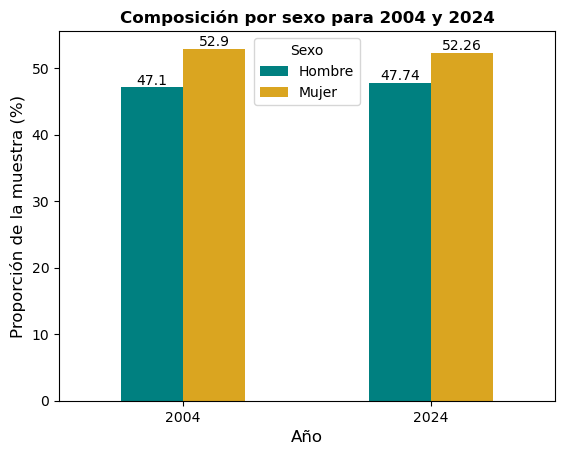

In [15]:
# #COMPOSICIÓN POR SEXO PARA 2004 Y 2024
# #CH04: Sexo. 1=Varón, 2=Mujer
# #ANO4: Año (2004, 2024)

#df_2004_GB['CH04'].value_counts(1).plot.bar()

# ax = df_2004_GB[['CH04']].plot(kind='bar', title ="Composición por sexo para 2004 y 2024", figsize=(15, 10), legend=True, fontsize=12)
# ax.set_xlabel("Año", fontsize=12)
# ax.set_ylabel("Cantidad", fontsize=12)
# plt.show()

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

comp_sexo = df_combined.groupby(['ANO4', 'CH04']).size().unstack(fill_value=0)
comp_ano = df_combined.groupby(['ANO4']).size()
comp_sexo_prop = round(comp_sexo.div(comp_ano, axis = 0)*100, 2)
labels= (comp_sexo_prop)
#.round(1).astype('str') + '%'

# Crear gráfico de barras
colores = ["teal", "goldenrod"]
ax = comp_sexo_prop.plot(kind='bar', color=colores)
ax.set_title('Composición por sexo para 2004 y 2024', fontdict={'fontsize': 12, 'fontweight': 'bold'})
ax.set_xlabel('Año', fontdict={'fontsize': 12})
ax.set_ylabel('Proporción de la muestra (%)', fontdict={'fontsize': 12})
plt.xticks(rotation=0)
plt.legend(['Hombre', 'Mujer'], title='Sexo', loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=1)

#Agregar etiquetas de altura a las barras
for container in ax.containers:
    ax.bar_label(container)

#me gustaria redondear mejor las etiquetas pero no me sale

plt.show()


In [16]:
comp_sexo
comp_sexo = df_combined.groupby(['ANO4', 'CH04']).size().unstack(fill_value=0)
comp_ano = df_combined.groupby(['ANO4']).size()
comp_sexo_prop = comp_sexo.div(comp_ano, axis = 0)*100

conteo_ano = comp_sexo.sum(axis=1)

print(comp_sexo)
print(conteo_ano)

print(comp_ano)



comp_sexo_prop


CH04     1     2
ANO4            
2004  3602  4045
2024  3360  3678
ANO4
2004    7647
2024    7038
dtype: int64
ANO4
2004    7647
2024    7038
dtype: int64


CH04,1,2
ANO4,,
2004,47.103439,52.896561
2024,47.740835,52.259165


Text(0.5, 1.0, 'Matriz de correlación - 2004')

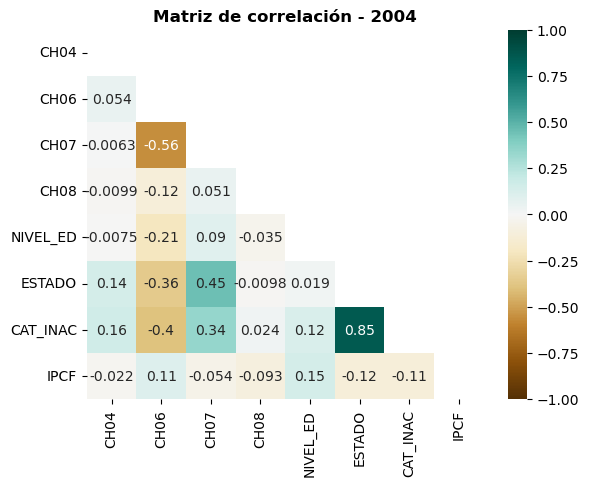

In [18]:
# #MATRIZ DE CORRELACIÓN

#UNA PARA 2004 Y OTRA PARA 2024

#2004
col_cor = ["CH04", "CH06", "CH07", 'CH08', 'NIVEL_ED', 'ESTADO', 'CAT_INAC', 'IPCF']


df_cor2004 = df_2004_GB[col_cor]
df_cor2024 = df_2024_GB[col_cor]

# Calcular la matriz de correlación
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
upp_mat2004 = np.triu(df_cor2004.corr())
cor04 = sns.heatmap(df_cor2004.corr(), vmin=-1, vmax=+1, annot=True, cmap="BrBG", mask=upp_mat2004)
cor04.set_title("Matriz de correlación - 2004",fontdict={'fontsize': 12, 'fontweight': 'bold'})


# axes[0].cor04
# axes[1].cor24
# fig.tight_layout()


Text(0.5, 1.0, 'Matriz de correlación - 2024')

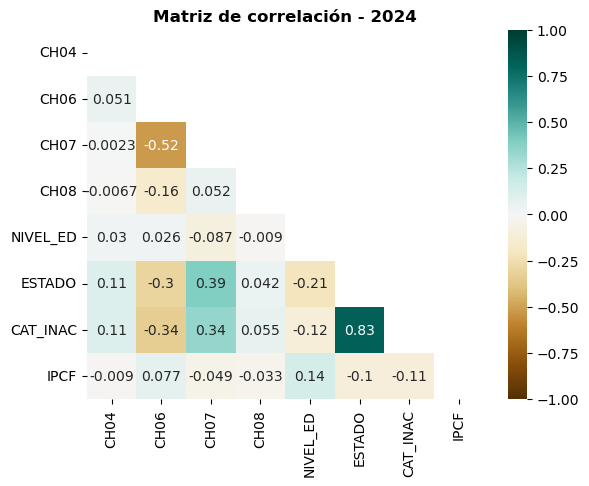

In [19]:
upp_mat2024 = np.triu(df_cor2024.corr())
cor24 = sns.heatmap(df_cor2024.corr(), vmin=-1, vmax=+1, annot=True, cmap="BrBG", mask=upp_mat2024)
cor24.set_title("Matriz de correlación - 2024", fontdict={'fontsize': 12, 'fontweight': 'bold'})

In [20]:
#ESTADO: 0 = Entrevista individual no realizada (no respuesta al cuestionario individual)
    # 1 = Ocupado
    # 2 = Desocupado
    # 3 = Inactivo
    # 4 = Menor de 10 años

print("Estado por año", df_combined["ESTADO"].groupby(df_combined["ANO4"]).value_counts())
print("Estado en total", df_combined["ESTADO"].value_counts())

Estado por año ANO4  ESTADO
2004  1         3079
      3         2800
      4         1230
      2          528
      0           10
2024  1         3224
      3         2662
      4          813
      2          311
      0           28
Name: count, dtype: int64
Estado en total ESTADO
1    6303
3    5462
4    2043
2     839
0      38
Name: count, dtype: int64


In [142]:
comp_estado[[2,3]]

ESTADO,2,3
ANO4,,
2004,528,2800
2024,311,2662


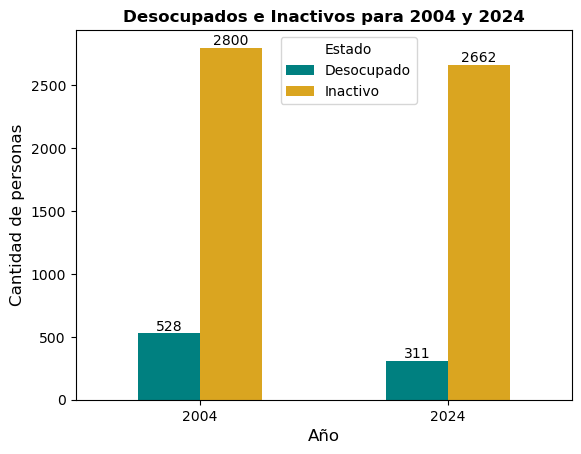

In [ ]:
comp_estado = df_combined.groupby(['ANO4', 'ESTADO']).size().unstack(fill_value=0)
comp_estado = comp_estado[[2,3]]
#comp_ano = df_combined.groupby(['ANO4']).size()
#comp_estado_prop = round(comp_sexo.div(comp_ano, axis = 0)*100, 2)
#labels= (comp_sexo_prop)
#.round(1).astype('str') + '%'

# Crear gráfico de barras
colores = ["teal", "goldenrod"]
ax = comp_estado.plot(kind='bar', color=colores)
ax.set_title('Desocupados e Inactivos para 2004 y 2024', fontdict={'fontsize': 12, 'fontweight': 'bold'})
ax.set_xlabel('Año', fontdict={'fontsize': 12})
ax.set_ylabel('Cantidad de personas', fontdict={'fontsize': 12})
plt.xticks(rotation=0)
plt.legend(['Desocupado', 'Inactivo'], title='Estado', loc='upper center', bbox_to_anchor=(0.55, 1.0), ncol=1)
plt.subplots_adjust()

#Agregar etiquetas de altura a las barras
for container in ax.containers:
    ax.bar_label(container)


plt.show()


In [123]:
#INGRESO PER CÁPITA FAMILIAR SEGÚN ESTADO (OCUPADO, DESOCUPADO, INACTIVO)
#IPCF: Monto de ingreso per capita familiar percibido
#ESTADO: 0 = Entrevista individual no realizada (no respuesta al cuestionario individual)
    # 1 = Ocupado
    # 2 = Desocupado
    # 3 = Inactivo
    # 4 = Menor de 10 años
# agg=['mean', 'count', 'min', 'max']
print("IPCF por estado, total\n", df_combined["IPCF"].groupby(df_combined["ESTADO"]).describe()) #PODRIAMOS SACAR LOS VALORES DE INGRESO EN CERO??
print("IPCF por estado, 2004\n", df_2004_GB["IPCF"].groupby(df_2004_GB["ESTADO"]).describe())
print("IPCF por estado, 2024\n", df_2024_GB["IPCF"].groupby(df_2024_GB["ESTADO"]).describe())


IPCF por estado, total
          count           mean            std  min   25%    50%      75%  \
ESTADO                                                                    
0         38.0      13.815789      53.735013  0.0   0.0    0.0      0.0   
1       6303.0  106443.281295  382731.337327  0.0  50.0  337.0  79800.0   
2        839.0   31655.797378   81410.436494  0.0  65.0  183.0    705.0   
3       5462.0   63862.957342  175238.209647  0.0  66.0  251.0  66750.0   
4       2043.0   41675.026432  123001.677718  0.0  58.0  183.0   1066.5   

               max  
ESTADO              
0            294.0  
1       11312333.0  
2         908750.0  
3        5875000.0  
4        1733333.0  
IPCF por estado, 2004
          count        mean          std  min    25%    50%     75%      max
ESTADO                                                                     
0         10.0   52.500000    98.051290  0.0    0.0    0.0   38.25    294.0
1       3079.0  475.869763  1090.246916  0.0  151.0 

In [122]:
df_2004_GB["IPCF"].groupby(df_2004_GB["ESTADO"]).describe()

,count,mean,std,min,25%,50%,75%,max
ESTADO,,,,,,,,
0,10.0,52.500000,98.051290,0.0,0.0,0.0,38.25,294.0
1,3079.0,475.869763,1090.246916,0.0,151.0,300.0,550.00,54000.0
2,528.0,224.022727,233.977138,0.0,85.0,160.0,297.25,2000.0
3,2800.0,315.706786,337.230996,0.0,120.0,210.0,400.00,4500.0
4,1230.0,246.034959,340.707278,0.0,84.0,152.5,300.00,4800.0


In [121]:
df_2024_GB["IPCF"].groupby(df_2024_GB["ESTADO"]).describe()

,count,mean,std,min,25%,50%,75%,max
ESTADO,,,,,,,,
0,28.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,3224.0,207644.788772,515216.846245,0.0,0.0,72500.0,266666.0,11312333.0
2,311.0,85019.067524,115656.512017,0.0,0.0,51600.0,125000.0,908750.0
3,2662.0,130704.543201,233028.226578,0.0,0.0,73041.5,184000.0,5875000.0
4,813.0,104353.574416,177520.697347,0.0,0.0,55555.0,133333.0,1733333.0


In [22]:
noresp_04 = df_2004_GB.loc[(df_2004_GB["ESTADO"]==0)] #10 personas en el 2004
noresp_24 = df_2024_GB.loc[(df_2024_GB["ESTADO"]==0)] #28 personas en el 2024

noresp_04
noresp_24

,ANO4,TRIMESTRE,NRO_HOGAR,COMPONENTE,H15,REGION,MAS_500,AGLOMERADO,PONDERA,CH03,...,GDECIFR,PDECIFR,ADECIFR,IPCF,DECCFR,IDECCFR,RDECCFR,GDECCFR,PDECCFR,ADECCFR
399,2024,1,1,2,2,1,S,33,4537,2,...,12.0,NaN,12,0,12,NaN,12,12.0,NaN,12
400,2024,1,1,3,2,1,S,33,4537,3,...,12.0,NaN,12,0,12,NaN,12,12.0,NaN,12
401,2024,1,1,4,2,1,S,33,4537,3,...,12.0,NaN,12,0,12,NaN,12,12.0,NaN,12
409,2024,1,1,1,2,1,S,33,122,1,...,12.0,NaN,12,0,12,NaN,12,12.0,NaN,12
5564,2024,1,1,1,2,1,S,33,1794,1,...,12.0,NaN,12,0,12,NaN,12,12.0,NaN,12
15241,2024,1,1,3,2,1,S,33,2159,2,...,12.0,NaN,12,0,12,NaN,12,12.0,NaN,12
17096,2024,1,1,1,2,1,S,33,3707,1,...,12.0,NaN,12,0,12,NaN,12,12.0,NaN,12
26078,2024,1,1,3,2,1,S,32,1585,3,...,12.0,NaN,12,0,12,NaN,12,12.0,NaN,12
26079,2024,1,1,4,2,1,S,32,1585,3,...,12.0,NaN,12,0,12,NaN,12,12.0,NaN,12
26204,2024,1,1,2,2,1,S,33,2238,6,...,12.0,NaN,12,0,12,NaN,12,12.0,NaN,12


In [23]:
#ARMAR BASE DE RESPONDIERON Y NO RESPONDIERON

respondieron= df_combined.loc[(df_combined["ESTADO"]>0)]

norespondieron = df_combined.loc[(df_combined["ESTADO"]==0)] #38 personas no respondieron. 

def det_pea(estado): 
    if estado in [1,2]: 
        return 1
    else: 
        return 0

respondieron["PEA"]= respondieron["ESTADO"].apply(det_pea)

def det_pet(edad): 
   if 15 <= edad <= 65: 
        return 1 
   else:
    return  0

respondieron["PET"]= respondieron["CH06"].apply(det_pet)

def det_deso(estado):
    if estado == 2: 
        return 1
    else: 
        return 0 
    
respondieron["desocupado"]= respondieron["ESTADO"].apply(det_deso)

def det_edadagrup(edad):
    if 15 <= edad < 25: 
        return "15-24"
    elif 25 <= edad < 35: 
        return "25-34"
    elif 35 <= edad < 45: 
        return "35-44"
    elif 45 <= edad < 55: 
        return "45-54"
    elif 55 <= edad <= 65: 
        return "35-44"
    else: 
        return "No PET"
    
    #return "15-24" if 15 <= edad < 25 else "25-34" if 25 <= edad < 35 else "35-44" if 35 <= edad < 45 else "45-54" if 45 <= edad < 55 else "55-65" if 55 <= edad <= 65 else 0

respondieron["edad_grupo"]= respondieron["CH06"].apply(det_edadagrup)


C:\Users\magda\AppData\Local\Temp\ipykernel_10216\1941478326.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  respondieron["PEA"]= respondieron["ESTADO"].apply(det_pea)
C:\Users\magda\AppData\Local\Temp\ipykernel_10216\1941478326.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron["PEA"]= respondieron["ESTADO"].apply(det_pea)
C:\Users\magda\AppData\Local\Temp\ipykernel_10216\1941478326.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

In [18]:
respondieron

,NRO_HOGAR,COMPONENTE,H15,ANO4,TRIMESTRE,REGION,MAS_500,AGLOMERADO,PONDERA,CH03,...,DECCFR,IDECCFR,RDECCFR,GDECCFR,PDECCFR,ADECCFR,PEA,PET,desocupado,edad_grupo
0,1.0,1.0,Sí,2004,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1299.0,Jefe,...,07,,06,06,,04,0,0,0,No PET
1,1.0,1.0,Sí,2004,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,2018.0,Jefe,...,00,,00,00,,00,1,0,0,No PET
2,1.0,1.0,Sí,2004,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1486.0,Jefe,...,07,,07,07,,05,0,0,0,No PET
3,1.0,1.0,Sí,2004,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1674.0,Jefe,...,08,,08,08,,06,1,1,0,45-54
4,1.0,2.0,Sí,2004,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1674.0,Cónyuge/Pareja,...,08,,08,08,,06,0,1,0,45-54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14676,1.0,1,1,2024,1,1,S,33,2818.0,1,...,12,NaN,12,12.0,NaN,12,0,0,0,No PET
14677,1.0,2,1,2024,1,1,S,33,2818.0,2,...,12,NaN,12,12.0,NaN,12,1,1,1,35-44
14678,1.0,3,1,2024,1,1,S,33,2818.0,3,...,12,NaN,12,12.0,NaN,12,1,1,0,25-34
14679,1.0,4,1,2024,1,1,S,33,2818.0,3,...,12,NaN,12,12.0,NaN,12,1,1,0,25-34


In [24]:
respondieron["ESTADO"].value_counts()

ESTADO
1    6303
3    5462
4    2043
2     839
Name: count, dtype: int64

In [20]:
respondieron["desocupado"].value_counts()

desocupado
0    13808
1      839
Name: count, dtype: int64

Total PET: 9568
Total PEA: 7142


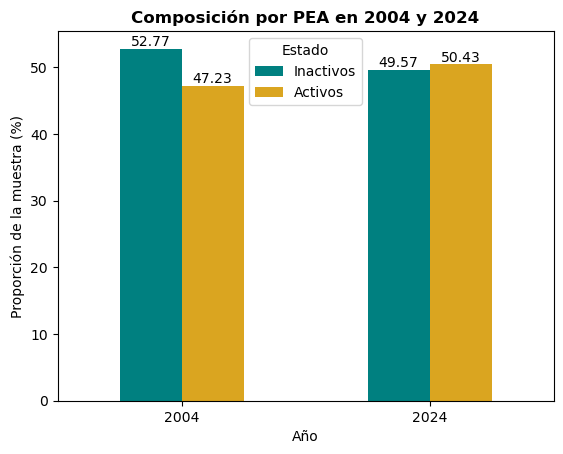

In [29]:
# Agrupar datos por año y PEA
comp_pea = respondieron.groupby(['ANO4', 'PEA']).size().unstack(fill_value=0)
comp_ano_r = respondieron.groupby(['ANO4']).size()
comp_pea_prop = round(comp_pea.div(comp_ano_r, axis = 0)*100, 2)
labels= (comp_pea_prop)

# Crear gráfico de barras
# comp_pea.plot(kind='bar')
# plt.title('Composición por PEA en 2004 y 2024')
# plt.xlabel('Año')
# plt.ylabel('Número de personas')
# plt.xticks(rotation=0)
# plt.legend(['No PEA', 'PEA'], title='PEA')
# plt.show()

# Comparar PET y PEA
total_pet = respondieron['PET'].sum()
total_pea = respondieron['PEA'].sum()

print(f'Total PET: {total_pet}')
print(f'Total PEA: {total_pea}')

# comp_sexo_prop = comp_sexo.div(comp_sexo.sum(axis=1), axis=0)
# labels= (comp_sexo_prop)
#.round(1).astype('str') + '%'

# Crear gráfico de barras
colores = ["teal", "goldenrod"]
ax = comp_pea_prop.plot(kind='bar', color=colores)
ax.set_title('Composición por PEA en 2004 y 2024', fontdict={'fontsize': 12, 'fontweight': 'bold'})
ax.set_xlabel('Año')
ax.set_ylabel('Proporción de la muestra (%)')
plt.xticks(rotation=0)
plt.legend(['Inactivos', 'Activos'], title='Estado', loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=1)

#Agregar etiquetas de altura a las barras
for container in ax.containers:
     ax.bar_label(container)

#me gustaria redondear mejor las etiquetas pero no me sale

plt.show()


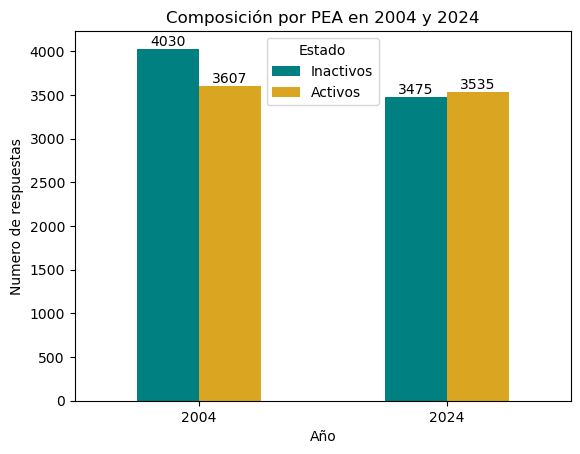

In [30]:
# Crear gráfico de barras
colores = ["teal", "goldenrod"]
ax = comp_pea.plot(kind='bar', color=colores)
ax.set_title('Composición por PEA en 2004 y 2024')
ax.set_xlabel('Año')
ax.set_ylabel('Numero de respuestas')
plt.xticks(rotation=0)
plt.legend(['Inactivos', 'Activos'], title='Estado', loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=1)

#Agregar etiquetas de altura a las barras
for container in ax.containers:
     ax.bar_label(container)

#me gustaria redondear mejor las etiquetas pero no me sale

plt.show()

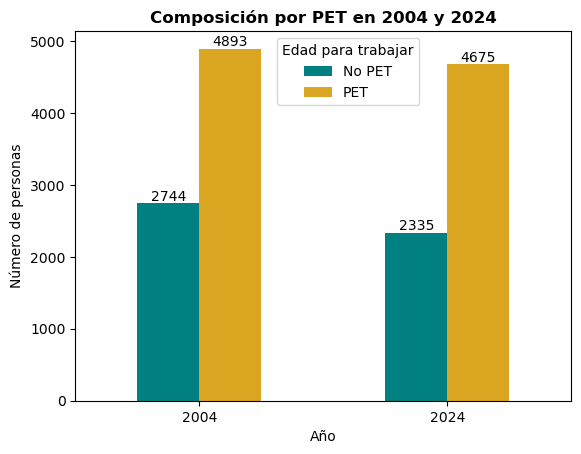

In [35]:
# Agrupar datos por año y PET
comp_pet = respondieron.groupby(['ANO4', 'PET']).size().unstack(fill_value=0)
comp_ano_r = respondieron.groupby(['ANO4']).size()
comp_pet_prop = round(comp_pet.div(comp_ano_r, axis = 0)*100, 2)
labels= (comp_pet_prop)

# Crear gráfico de barras
# comp_pea.plot(kind='bar')
# plt.title('Composición por PEA en 2004 y 2024')
# plt.xlabel('Año')
# plt.ylabel('Número de personas')
# plt.xticks(rotation=0)
# plt.legend(['No PEA', 'PEA'], title='PEA')
# plt.show()


# comp_sexo_prop = comp_sexo.div(comp_sexo.sum(axis=1), axis=0)
# labels= (comp_sexo_prop)
#.round(1).astype('str') + '%'

# Crear gráfico de barras
colores = ["teal", "goldenrod"]
ax = comp_pet.plot(kind='bar', color=colores)
ax.set_title('Composición por PET en 2004 y 2024', fontdict={'fontsize': 12, 'fontweight': 'bold'})
ax.set_xlabel('Año')
ax.set_ylabel('Número de personas')
plt.xticks(rotation=0)
plt.legend(['No PET', 'PET'], title='Edad para trabajar', loc='upper center', bbox_to_anchor=(0.55, 1.0), ncol=1) #arreglar position

#Agregar etiquetas de altura a las barras
for container in ax.containers:
     ax.bar_label(container)

#me gustaria redondear mejor las etiquetas pero no me sale

plt.show()

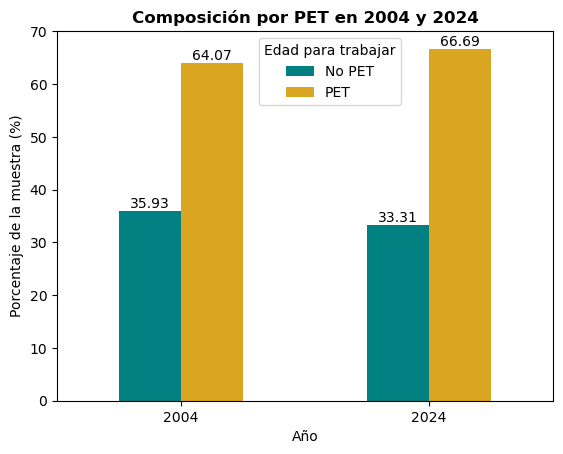

In [37]:
# Crear gráfico de barras
colores = ["teal", "goldenrod"]
ax = comp_pet_prop.plot(kind='bar', color=colores)
ax.set_title('Composición por PET en 2004 y 2024', fontdict={'fontsize': 12, 'fontweight': 'bold'})
ax.set_xlabel('Año')
ax.set_ylabel('Porcentaje de la muestra (%)')
plt.xticks(rotation=0)
plt.legend(['No PET', 'PET'], title='Edad para trabajar', loc='upper center', bbox_to_anchor=(0.55, 1.0), ncol=1) #arreglar position

#Agregar etiquetas de altura a las barras
for container in ax.containers:
     ax.bar_label(container)

#me gustaria redondear mejor las etiquetas pero no me sale

plt.show()

In [21]:
respondieron["desocupado"].groupby(respondieron["ANO4"]).value_counts()

ANO4  desocupado
2004  0             7109
      1              528
2024  0             6699
      1              311
Name: count, dtype: int64

In [ ]:
# nivel_ed= {
#     'Primaria Incompleta (incluye educación especial)': 1,
#     'Primaria Completa': 2,
#     'Secundaria Incompleta': 3,
#     'Secundaria Completa': 4,
#     'Superior Universitaria Incompleta': 5,
#     'Superior Universitaria Completa': 6,
#     'Sin instrucción': 7,
#     'Ns/Nr': 9
# }

In [63]:
respondieron["desocupado"].groupby(respondieron["NIVEL_ED"]).value_counts()

NIVEL_ED  desocupado
1         0             2226
          1               45
2         0             2223
          1              142
3         0             2614
          1              162
4         0             2417
          1              267
5         0             1419
          1              156
6         0             1685
          1               64
7         0             1224
          1                3
Name: count, dtype: int64

In [ ]:
respondieron["NIVEL_ED"].groupby(respondieron['ANO4']).value_counts() #cantidad de respuestas por nivel educativo por ano

ANO4  NIVEL_ED
2004  2           1625
      1           1405
      3           1372
      4           1083
      7            805
      5            700
      6            647
2024  4           1601
      3           1404
      6           1102
      5            875
      1            866
      2            740
      7            422
Name: count, dtype: int64

In [38]:
deso_df = respondieron.query("desocupado == 1") #df con solo desocupados

deso_df["NIVEL_ED"].groupby(deso_df['ANO4']).value_counts()

ANO4  NIVEL_ED
2004  4           137
      2           107
      3           107
      5            95
      1            43
      6            36
      7             3
2024  4           130
      5            61
      3            55
      2            35
      6            28
      1             2
Name: count, dtype: int64

In [39]:
deso_df.groupby(['ANO4', 'NIVEL_ED']).size().unstack(fill_value=0)

NIVEL_ED,1,2,3,4,5,6,7
ANO4,,,,,,,
2004,43,107,107,137,95,36,3
2024,2,35,55,130,61,28,0


In [26]:
deso_df.groupby(['ANO4', 'edad_grupo']).size().unstack(fill_value=0)

edad_grupo,15-24,25-34,35-44,45-54,No PET
ANO4,,,,,
2004,209,124,118,58,19
2024,108,64,81,49,9


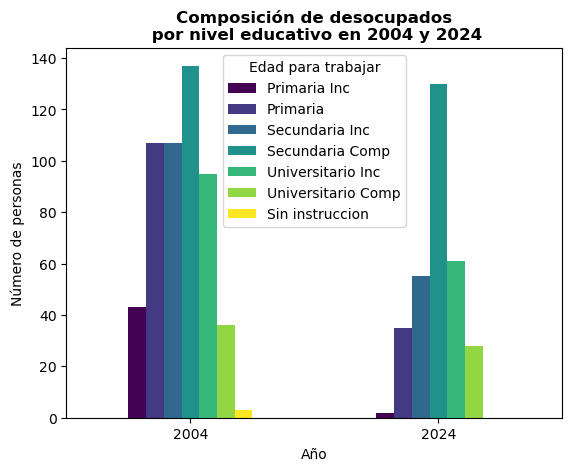

In [42]:
comp_deso = deso_df.groupby(['ANO4', 'NIVEL_ED']).size().unstack(fill_value=0)

# colores = ["teal", "goldenrod",'']
ax = comp_deso.plot(kind='bar', cmap='viridis')
ax.set_title('Composición de desocupados\n por nivel educativo en 2004 y 2024', fontdict={'fontsize': 12, 'fontweight': 'bold'})
ax.set_xlabel('Año')
ax.set_ylabel('Número de personas')
plt.xticks(rotation=0)
plt.legend(['Primaria Inc', 'Primaria', 'Secundaria Inc', 'Secundaria Comp', 'Universitario Inc', 'Universitario Comp', 'Sin instruccion'], title='Edad para trabajar') #arreglar position

# #Agregar etiquetas de altura a las barras
# for container in ax.containers:
#      ax.bar_label(container)

# nivel_ed= {
#     'Primaria Incompleta (incluye educación especial)': 1,
#     'Primaria Completa': 2,
#     'Secundaria Incompleta': 3,
#     'Secundaria Completa': 4,
#     'Superior Universitaria Incompleta': 5,
#     'Superior Universitaria Completa': 6,
#     'Sin instrucción': 7,
#     'Ns/Nr': 9

#me gustaria redondear mejor las etiquetas pero no me sale

plt.show()

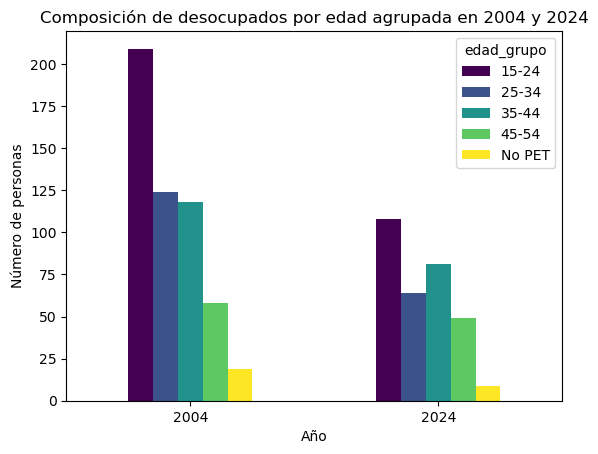

In [31]:
comp_deso_edad = deso_df.groupby(['ANO4', 'edad_grupo']).size().unstack(fill_value=0)

# colores = ["teal", "goldenrod",'']
ax = comp_deso_edad.plot(kind='bar', cmap='viridis')
ax.set_title('Composición de desocupados por edad agrupada en 2004 y 2024')
ax.set_xlabel('Año')
ax.set_ylabel('Número de personas')
plt.xticks(rotation=0)
#plt.legend(['Primaria Inc', 'Primaria', 'Secundaria Inc', 'Secundaria Comp', 'Universitario Inc', 'Universitario Comp', 'Sin instruccion'], title='Edad para trabajar') #arreglar position

# #Agregar etiquetas de altura a las barras
# for container in ax.containers:
#      ax.bar_label(container)

# nivel_ed= {
#     'Primaria Incompleta (incluye educación especial)': 1,
#     'Primaria Completa': 2,
#     'Secundaria Incompleta': 3,
#     'Secundaria Completa': 4,
#     'Superior Universitaria Incompleta': 5,
#     'Superior Universitaria Completa': 6,
#     'Sin instrucción': 7,
#     'Ns/Nr': 9

#me gustaria redondear mejor las etiquetas pero no me sale

plt.show()

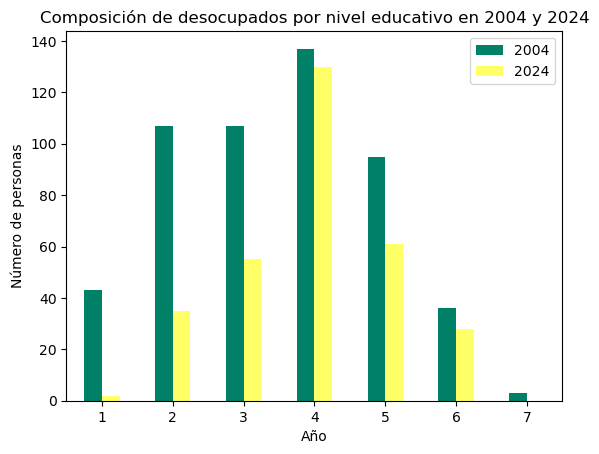

In [83]:
comp_deso = deso_df.groupby(['NIVEL_ED', 'ANO4']).size().unstack(fill_value=0)

# colores = ["teal", "goldenrod",'']
ax = comp_deso.plot(kind='bar', cmap='summer')
ax.set_title('Composición de desocupados por nivel educativo en 2004 y 2024')
ax.set_xlabel('Año')
ax.set_ylabel('Número de personas')
plt.xticks(rotation=0)
plt.legend(['2004', '2024']) #arreglar position

# #Agregar etiquetas de altura a las barras
# for container in ax.containers:
#      ax.bar_label(container)

# nivel_ed= {
#     'Primaria Incompleta (incluye educación especial)': 1,
#     'Primaria Completa': 2,
#     'Secundaria Incompleta': 3,
#     'Secundaria Completa': 4,
#     'Superior Universitaria Incompleta': 5,
#     'Superior Universitaria Completa': 6,
#     'Sin instrucción': 7,
#     'Ns/Nr': 9

#me gustaria redondear mejor las etiquetas pero no me sale

plt.show()

In [33]:
respondieron['desocupado'].value_counts()

desocupado
0    13808
1      839
Name: count, dtype: int64

### Parte III: Clasificaciones

##### Reset de respondieron

In [17]:
# RESET
#ARMAR BASE DE RESPONDIERON Y NO RESPONDIERON

respondieron= df_combined.loc[(df_combined["ESTADO"]>0)]

norespondieron = df_combined.loc[(df_combined["ESTADO"]==0)] #38 personas no respondieron. 

def det_pea(estado): 
    return 1 if estado in [1,2] else 0

respondieron["PEA"]= respondieron["ESTADO"].apply(det_pea)
norespondieron["PEA"]= norespondieron["ESTADO"].apply(det_pea)

def det_pet(edad): 
    return 1 if 15 <= edad <= 65 else 0

respondieron["PET"]= respondieron["CH06"].apply(det_pet)
norespondieron["PET"]= norespondieron["CH06"].apply(det_pet)

def det_deso(estado): 
    return 1 if estado == 2 else 0

respondieron["desocupado"]= respondieron["ESTADO"].apply(det_deso)

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_14884\417710464.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  respondieron["PEA"]= respondieron["ESTADO"].apply(det_pea)
C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_14884\417710464.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron["PEA"]= respondieron["ESTADO"].apply(det_pea)
C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_14884\417710464.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

#### División de train y test para respondieron
1. Agrego algunos diccionarios más que no se pierdan las variables categoricas de 2004 (se pueden agregar más)
2. Transformo las columnas acorde a los dic
3. Hago un df más chico, que elimina todas las variables categoricas restantes

4. separo la base por año por si hay que modificar algo del año en particular
5. separo en train y test

##### diccionarios de algunas columnas más

In [18]:
#Voy corrigiendo columnas acorde a lo que me pide la regresión
componente = {
    'Servicio doméstico en hogares': 51
}

h15 = {
    "Sí": 1,
    "No": 2
}

mas_500 = {
    'N' : 1,
    'S' : 0
} # controversial

aglomerado = {
    'Ciudad de Buenos Aires' : 32,
    'Partidos del GBA' : 33

}

ch03 = {
    'Jefe' : 1,
    'Cónyuge/Pareja' : 2,
    'Hijo/Hijastro' : 3,
    'Yerno/Nuera' : 4,
    'Nieto' : 5,
    'Madre/Padre' : 6,
    'Suegro' : 7,
    'Hermano' : 8,
    'Otros familiares' : 9,
    'No familiares' : 10,
}

ch09 = {
    "Sí": 1,
    "No": 2,
    "Menor de 2 años": 3,
    'Ns./Nr.' : 0 # había 2 datos de Ns./Nr que no esta en el diccionario, cuidado
}

ch10 = {
    "Sí, asiste": 1,
    "No asiste, pero asistió": 2,
    "Nunca asistió": 3 #hay 263 datos que son 0.0, cuidado (NO DEBERAÍN ESTAR) 
}

In [19]:
respondieron.loc[:,'COMPONENTE'] = respondieron['COMPONENTE'].replace(componente).astype(int)
respondieron.loc[:,'H15'] = respondieron['H15'].replace(h15).astype(int)
respondieron.loc[:,'MAS_500'] = respondieron['MAS_500'].replace(mas_500).astype(int)
respondieron.loc[:,'AGLOMERADO'] = respondieron['AGLOMERADO'].replace(aglomerado).astype(int)
respondieron.loc[:, 'CH03'] = respondieron['CH03'].replace(ch03).astype(int)
respondieron.loc[:, 'CH09'] = respondieron['CH09'].replace(ch09).astype(int) # hay 2 valores 9 que no debería estar
respondieron.loc[:, 'CH10'] = respondieron['CH10'].replace(ch10).astype(int) # hay 364 valores que son 0 y 2 que son 9 que no deberían ser

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_14884\1684392245.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  respondieron.loc[:,'COMPONENTE'] = respondieron['COMPONENTE'].replace(componente).astype(int)
C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_14884\1684392245.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  respondieron.loc[:,'H15'] = respondieron['H15'].replace(h15).astype(int)
C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_14884\1684392245.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and wil

In [20]:
norespondieron.loc[:,'COMPONENTE'] = norespondieron['COMPONENTE'].replace(componente).astype(int)
norespondieron.loc[:,'H15'] = norespondieron['H15'].replace(h15).astype(int)
norespondieron.loc[:,'MAS_500'] = norespondieron['MAS_500'].replace(mas_500).astype(int)
norespondieron.loc[:,'AGLOMERADO'] = norespondieron['AGLOMERADO'].replace(aglomerado).astype(int)
norespondieron.loc[:, 'CH03'] = norespondieron['CH03'].replace(ch03).astype(int)
norespondieron.loc[:, 'CH09'] = norespondieron['CH09'].replace(ch09).astype(int) # hay 2 valores 9 que no debería estar
norespondieron.loc[:, 'CH10'] = norespondieron['CH10'].replace(ch10).astype(int) # hay 364 valores que son 0 y 2 que son 9 que no deberían ser

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_14884\49249457.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  norespondieron.loc[:,'COMPONENTE'] = norespondieron['COMPONENTE'].replace(componente).astype(int)
C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_14884\49249457.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  norespondieron.loc[:,'H15'] = norespondieron['H15'].replace(h15).astype(int)
C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_14884\49249457.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and w

### Definición de NO RESPONDIERON

In [56]:
respondieron = respondieron.drop('P47T', axis=1)

In [21]:
lista_nans = norespondieron.columns[norespondieron.isnull().any()].tolist()
norespondieron = norespondieron.drop(lista_nans, axis=1)

In [22]:
noresp_04 = norespondieron[norespondieron['ANO4'] == 2004]
noresp_24 = norespondieron[norespondieron['ANO4'] == 2024]
noresp_04 = noresp_04.select_dtypes(include='number')
noresp_24 = noresp_24.select_dtypes(include='number')

##### separo años

In [57]:
lista_nans = respondieron.columns[respondieron.isnull().any()].tolist()
respondieron = respondieron.drop(lista_nans, axis=1)

In [58]:
again_04 = respondieron[respondieron['ANO4'] == 2004]
again_24 = respondieron[respondieron['ANO4'] == 2024]
again_04_selec = again_04.select_dtypes(include='number')
again_24_selec = again_24.select_dtypes(include='number')


In [59]:
again_04_selec['desocupado'].value_counts()

desocupado
0    7109
1     528
Name: count, dtype: int64

In [60]:
X_2004 = again_04_selec.drop(columns=['desocupado'])
y_2004 = again_04_selec['desocupado']
X_2024 = again_24_selec.drop(columns=['desocupado'])
y_2024 = again_24_selec['desocupado']

In [61]:
#Chequeo si hay columnas que tengan Nan
X_2024.isnull().values.any()
for i in X_2004:
    if X_2004[i].isnull().values.any() == True:
        print (i)

In [62]:
#VAMOS A USAR SOLO LAS VARIABLES QUE ESTAN EN LA MATRIZ DE CORRELACION, PARA QUE SEA MAS FACIL!!!! son un poco más, pero están clean

x_train_24, x_test_24, y_train_24, y_test_24 = train_test_split(X_2024, y_2024, test_size=0.3, random_state=101)
x_train_04, x_test_04, y_train_04, y_test_04 = train_test_split(X_2004, y_2004, test_size=0.3, random_state=101)

x_train_04 = sm.add_constant(x_train_04) #AGREGO COLUMNA DE UNOS
x_train_24 = sm.add_constant(x_train_24)


##### Clasificación

In [63]:
# Para cada año, partan la base respondieron en una base de prueba
#  (test) y una de entrenamiento (train) utilizando el comando
#  train_test_split. La base de entrenamiento debe comprender el 70%
#  de los datos, y la semilla a utilizar (random state instance) debe ser 101.
#  Establezca a desocupado como su variable dependiente en la base de
#  entrenamiento (vector y). El resto de las variables serán las variables
#  independientes (matriz X). Recuerden agregar la columna de unos (1)


# y_04 = train_2004['desocupado']
# x_04 = train_2004.drop(columns=['desocupado'])
# x_04 = np.c_[np.ones(x_04.shape[0]), x_04]

# y_04 = y_train_04['desocupado']
# x_04 = x_train_04[["CH04", "CH06", "CH07", 'CH08', 'NIVEL_ED', 'ESTADO', 'CAT_INAC', 'IPCF', 'PET', 'PEA', 'ANO4', 'PONDERA']]


# X_sm = sm.add_constant(x_04) 
# logit_model = sm.Logit(y_04, X_sm)
# result = logit_model.fit()
# print(result.summary2()) 

In [64]:
# y_04 = train_2004['desocupado']
# X_04 = train_2004.drop(columns=['desocupado'])

# # Agregar columna de unos para la matriz X
# X_04 = np.c_[np.ones(X_04.shape[0]), X_04]

# Dividir el conjunto de datos en entrenamiento y prueba (70% - 30%)
# X_train, X_test, y_train, y_test = train_test_split(X_04, y_04, test_size=0.3, random_state=101)

# Mostrar las formas de los conjuntos
# print("X_train shape:", x_train_24.shape)
# print("X_test shape:", x_test_24.shape)
# print("y_train shape:", y_train_24.shape)
# print("y_test shape:", y_test_24.shape)

#### REGRESION LOGISTICA

In [65]:
#### Regresion logistica para 2004
log04 = LogisticRegression(penalty=None).fit(x_train_04, y_train_04)
y_test_pred_score_04 = log04.predict_proba(x_train_04)[:,1]
y_pred_log04 = log04.predict(x_test_04)

#### Regresion logistica para 2024
log24 = LogisticRegression(penalty=None).fit(x_train_24, y_train_24)
y_test_pred_score_24 = log24.predict_proba(x_train_24)[:,1]
y_pred_log24 = log24.predict(x_test_24)

c:\Users\SAMSUNG\AnitaConda7\envs\Clasestuto\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\SAMSUNG\AnitaConda7\envs\Clasestuto\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

Matriz de confusion (Reg Log 2004)
 [[2096   37]
 [ 126   33]]

AUC Reg Log (2004): 0.5951


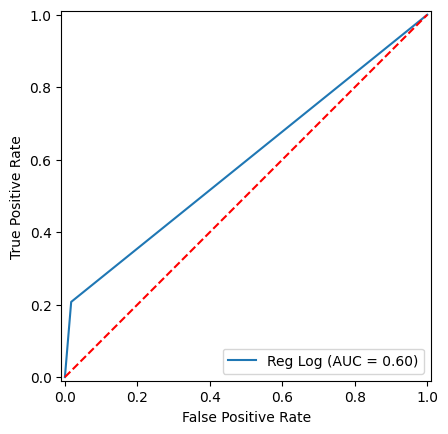

La accuracy del modelo (Reg Log 2004) es: 0.9289


In [66]:
#### Medidas de precision Regresion logistica para 2004
#Matriz de confusion
conflog04 = confusion_matrix(y_test_04, y_pred_log04) 
print("Matriz de confusion (Reg Log 2004)\n", conflog04)

#AUC
auc_log04 = roc_auc_score(y_test_04, y_pred_log04)
print('\nAUC Reg Log (2004): %.4f' %auc_log04)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_04, y_pred_log04)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_log04, estimator_name='Reg Log')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#Accuracy
accuracy_log04 = accuracy_score(y_test_04, y_pred_log04)
print("La accuracy del modelo (Reg Log 2004) es: %.4f" %accuracy_log04)

Matriz de confusion (Reg Log 2024)
 [[1995    1]
 [ 105    2]]

AUC Reg Log (2024): 0.5091


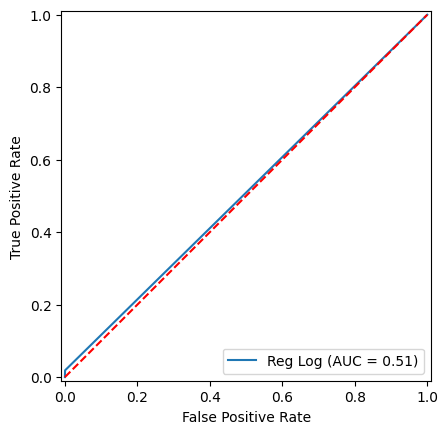

La accuracy del modelo (Reg Log 2024) es: 0.9496


In [67]:
#### Medidas de precision Regresion logistica para 2024
#Matriz de confusion
conflog24 = confusion_matrix(y_test_24, y_pred_log24) 
print("Matriz de confusion (Reg Log 2024)\n", conflog24)

#AUC
auc_log24 = roc_auc_score(y_test_24, y_pred_log24)
print('\nAUC Reg Log (2024): %.4f' %auc_log24)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_24, y_pred_log24)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_log24, estimator_name='Reg Log')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#Accuracy
accuracy_log24 = accuracy_score(y_test_24, y_pred_log24)
print("La accuracy del modelo (Reg Log 2024) es: %.4f" %accuracy_log24)

In [68]:
#REGRESION LOGISTICA

# log_reg_2004 = LogisticRegression(penalty = None).fit(x_train_04, y_train_04)
# y_test_pred_score_2004 = log_reg_2004.predict_proba(x_train_04)[:,1]
# y_test_pred_2004 = log_reg_2004.predict(x_test_04)

# # Gráfico de resultados
# plt.figure(figsize=(6, 4))
# plt.scatter(y_train_04, y_test_pred_score_2004, color='red', zorder=20)
# plt.show()

# Ajustamos el clasificador con el método fit() 
#log_reg_2004 = LogisticRegression(penalty=None).fit(X_2004, y_2004)

# Predicciones (probabilidad)
#y_pred_score = log_reg_2004.predict_proba(X_2004)[:,1]   # Por qué seleccionamos la columna 1?


#log_reg_2004 = LogisticRegression(penalty=None).fit(X_2004, y_2004)


#### LDA

In [75]:
#### LDA para 2004
lda04 = LinearDiscriminantAnalysis(n_components=1)
lda04 = lda04.fit(x_train_04, y_train_04)
y_pred_lda04 = lda04.predict(x_test_04)

#### LDA para 2024
lda24 = LinearDiscriminantAnalysis(n_components=1)
lda24 = lda24.fit(x_train_24, y_train_24)
y_pred_lda24 = lda24.predict(x_test_24)

Matriz de confusion (LDA 2004)
 [[2128    5]
 [   1  158]]

AUC LDA (2004): 0.9957


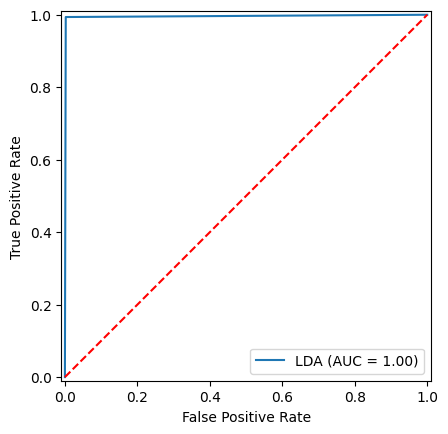

La accuracy del modelo (2004) es: 0.9974


In [76]:
#### Medidas de precision LDA para 2004
#Matriz de confusion
conflda04 = confusion_matrix(y_test_04, y_pred_lda04) 
print("Matriz de confusion (LDA 2004)\n", conflda04)

#AUC
auc_lda04 = roc_auc_score(y_test_04, y_pred_lda04)
print('\nAUC LDA (2004): %.4f' %auc_lda04)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_04, y_pred_lda04)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_lda04, estimator_name='LDA')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#Accuracy
accuracy_lda04 = accuracy_score(y_test_04, y_pred_lda04)
print("La accuracy del modelo (2004) es: %.4f" %accuracy_lda04)


Matriz de confusion (LDA 2024)
 [[1996    0]
 [   0  107]]

AUC LDA (2024) 1.0


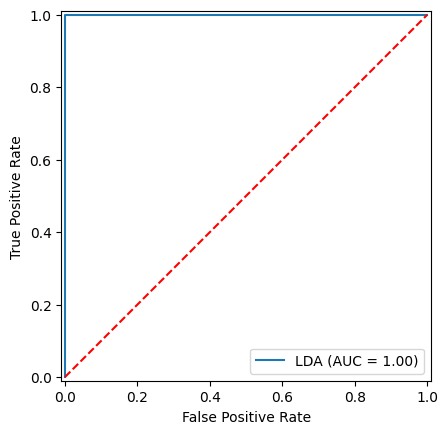

La accuracy del modelo (2024) es:  1.0


In [77]:
#### Medidas de precision LDA para 2024
#Matriz de confusion
conflda24 = confusion_matrix(y_test_24, y_pred_lda24) 
print("Matriz de confusion (LDA 2024)\n", conflda24)

#AUC
auc_lda24 = roc_auc_score(y_test_24, y_pred_lda24)
print('\nAUC LDA (2024)', auc_lda24)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_24, y_pred_lda24)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_lda24, estimator_name='LDA')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#Accuracy
accuracy_lda24 = accuracy_score(y_test_24, y_pred_lda24)
print("La accuracy del modelo (2024) es: ", accuracy_lda24)

#### KNN

In [78]:
#### KNN para 2004

knn04 = KNeighborsClassifier(n_neighbors=3)
knn04.fit(x_train_04, y_train_04)
y_pred_knn04 = knn04.predict(x_test_04)

#### KNN para 2024
knn24 = KNeighborsClassifier(n_neighbors=3)
knn24.fit(x_train_24, y_train_24)
y_pred_knn24 = knn24.predict(x_test_24)

Matriz de confusion (KNN 2004)
 [[2074   59]
 [ 133   26]]

AUC KNN (2004): 0.5679


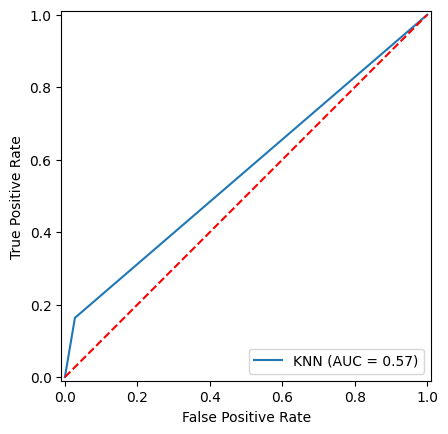

La accuracy del modelo KNN (2004) es: 0.9162


In [79]:
#Medidas de precision KNN (2004)
confknn04 = confusion_matrix(y_test_04, y_pred_knn04) 
print("Matriz de confusion (KNN 2004)\n", confknn04)

#AUC
auc_knn04 = roc_auc_score(y_test_04, y_pred_knn04)
print('\nAUC KNN (2004): %.4f' %auc_knn04)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_04, y_pred_knn04)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_knn04, estimator_name='KNN')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#Accuracy
accuracy_knn04 = accuracy_score(y_test_04, y_pred_knn04)
print("La accuracy del modelo KNN (2004) es: %.4f" %accuracy_knn04)

Matriz de confusion (KNN 2024)
 [[1977   19]
 [ 101    6]]

AUC KNN (2024): 0.5233


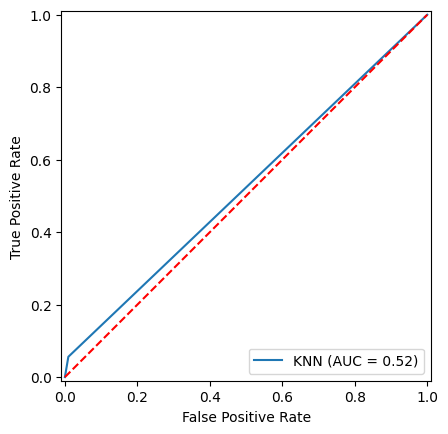

La accuracy del modelo KNN (2024) es: 0.9429


In [80]:
#Medidas de precision KNN (2004)
confknn24 = confusion_matrix(y_test_24, y_pred_knn24) 
print("Matriz de confusion (KNN 2024)\n", confknn24)

#AUC
auc_knn24 = roc_auc_score(y_test_24, y_pred_knn24)
print('\nAUC KNN (2024): %.4f' %auc_knn24)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_24, y_pred_knn24)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_knn24, estimator_name='KNN')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#Accuracy
accuracy_knn24 = accuracy_score(y_test_24, y_pred_knn24)
print("La accuracy del modelo KNN (2024) es: %.4f" %accuracy_knn24)

#### NAIVE BAYES


In [81]:
from sklearn.naive_bayes import GaussianNB

In [82]:
#### NB para 2004
nb04 = GaussianNB() 
nb04 = nb04.fit(x_train_04, y_train_04)
y_pred_nb04 = nb04.predict(x_test_04)

#### NB para 2024
nb24 = GaussianNB() 
nb24 = nb24.fit(x_train_24, y_train_24)
y_pred_nb24 = nb24.predict(x_test_24)

Matriz de confusion (NB 2004)
 [[2133    0]
 [   2  157]]

AUC NB (2004): 0.9937


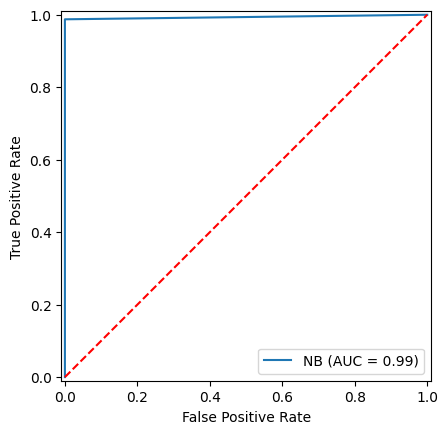

La accuracy del modelo NB (2004) es: 0.9991


In [83]:
#Medidas de precision Naive Bayes (2004)
confnb04 = confusion_matrix(y_test_04, y_pred_nb04) 
print("Matriz de confusion (NB 2004)\n", confnb04)

#AUC
auc_nb04 = roc_auc_score(y_test_04, y_pred_nb04)
print('\nAUC NB (2004): %.4f' %auc_nb04)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_04, y_pred_nb04)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_nb04, estimator_name='NB')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#Accuracy
accuracy_nb04 = accuracy_score(y_test_04, y_pred_nb04)
print("La accuracy del modelo NB (2004) es: %.4f" %accuracy_nb04)

Matriz de confusion (NB 2024)
 [[ 716 1280]
 [   1  106]]

AUC NB (2024): 0.6747


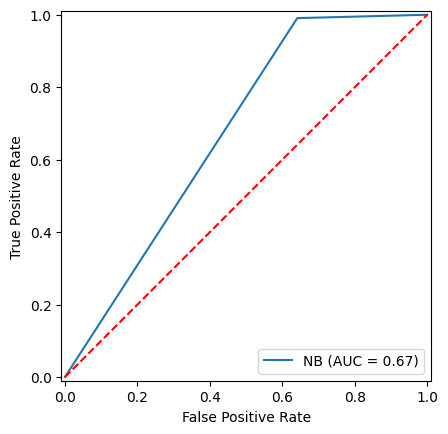

La accuracy del modelo NB (2024) es: 0.3909


In [84]:
#Medidas de precision Naive Bayes (2024)
confnb24 = confusion_matrix(y_test_24, y_pred_nb24) 
print("Matriz de confusion (NB 2024)\n", confnb24)

#AUC
auc_nb24 = roc_auc_score(y_test_24, y_pred_nb24)
print('\nAUC NB (2024): %.4f' %auc_nb24)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_24, y_pred_nb24)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_nb24, estimator_name='NB')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#Accuracy
accuracy_nb24 = accuracy_score(y_test_24, y_pred_nb24)
print("La accuracy del modelo NB (2024) es: %.4f" %accuracy_nb24)

### sELECCIÓN DEL MODELO

In [ ]:
#Con el método que seleccionaron, predigan qué personas son
#  desocupadas dentro de la base norespondieron. ¿Qué proporción de las
#  personas que no respondieron pudieron identificar como desocupadas

In [ ]:
# Base no respondieron


###### POnele que REgre

In [97]:
pred_noresp04 = log04.predict(noresp_04)

In [101]:
y_pred_reg_04 = pd.Series(pred_noresp04.tolist())

In [102]:
y_pred_reg_04.value_counts()

0    5
1    5
Name: count, dtype: int64

###### Ponele que Lda

In [94]:
#ponele q elegimos lda
lda04 = LinearDiscriminantAnalysis(n_components=1)
lda04 = lda04.fit(x_train_04, y_train_04)
pred_noresp04 = lda04.predict(noresp_04)

# 24
lda24 = LinearDiscriminantAnalysis(n_components=1)
lda24 = lda24.fit(x_train_24, y_train_24)
pred_noresp24 = lda24.predict(noresp_24)

In [95]:
y_pred_lda_24 = pd.Series(pred_noresp24.tolist())
len(y_pred_lda_24)

28

In [91]:
y_pred_lda = pd.Series(pred_noresp04.tolist())
len(y_pred_lda)

10

In [96]:
y_pred_lda_24.value_counts()

0    28
Name: count, dtype: int64

### Prueba con las bases de x 04 estandarizadas

In [26]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# Estandarizamos las observaciones de entrenamiento
x_train_04est = pd.DataFrame(sc.fit_transform(x_train_04), index=x_train_04.index, columns=x_train_04.columns)

# Estandarizamos las observaciones de test
x_test_04est = pd.DataFrame(sc.transform(x_test_04), index=x_test_04.index, columns=x_test_04.columns) #la diferencia es ??? ver clase grabada. o preguntar a nacho. 

# y_train_04est = pd.DataFrame(sc.transform(y_train_04), index=y_train_04.index, columns=y_train_04.columns)
# y_test_04est = pd.DataFrame(sc.transform(y_test_04), index=y_test_04.index, columns=y_test_04.columns)

NameError: name 'x_train_04' is not defined

knn con x estandarizado

In [ ]:
knn04est = KNeighborsClassifier(n_neighbors=3)
knn04est.fit(x_train_04est, y_train_04)
y_pred_knn04est = knn04est.predict(x_test_04est)

Matriz de confusion (KNN 2004)
 [[2128    5]
 [  35  124]]

AUC KNN (2004): 0.8888


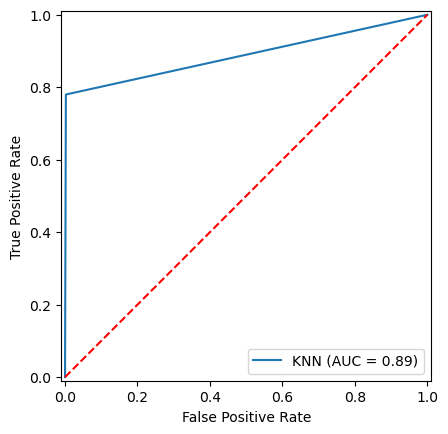

La accuracy del modelo KNN (2004) es: 0.9825


In [ ]:
#Medidas de precision KNN (2004)
confknn04est = confusion_matrix(y_test_04, y_pred_knn04est) 
print("Matriz de confusion (KNN 2004)\n", confknn04est)

#AUC
auc_knn04est = roc_auc_score(y_test_04, y_pred_knn04est)
print('\nAUC KNN (2004): %.4f' %auc_knn04est)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_04, y_pred_knn04est)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_knn04est, estimator_name='KNN')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#Accuracy
accuracy_knn04est = accuracy_score(y_test_04, y_pred_knn04est)
print("La accuracy del modelo KNN (2004) es: %.4f" %accuracy_knn04est)

Reg log con x estandarizado


In [ ]:
log04est = LogisticRegression(penalty=None).fit(x_train_04est, y_train_04)
y_test_pred_score_04est = log04.predict_proba(x_train_04est)[:,1]
y_pred_log04est = log04est.predict(x_test_04est)

Matriz de confusion (Reg Log 2004)
 [[2133    0]
 [   0  159]]

AUC Reg Log (2004): 1.0000


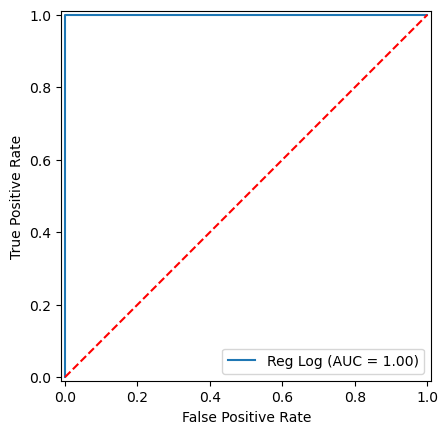

La accuracy del modelo (Reg Log 2004) es: 1.0000


In [ ]:
#Matriz de confusion
conflog04est = confusion_matrix(y_test_04, y_pred_log04est) 
print("Matriz de confusion (Reg Log 2004)\n", conflog04est)

#AUC
auc_log04est = roc_auc_score(y_test_04, y_pred_log04est)
print('\nAUC Reg Log (2004): %.4f' %auc_log04est)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_04, y_pred_log04est)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_log04est, estimator_name='Reg Log')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#Accuracy
accuracy_log04est = accuracy_score(y_test_04, y_pred_log04est)
print("La accuracy del modelo (Reg Log 2004) es: %.4f" %accuracy_log04est)